Marcos Caballero Cortés, Roger Juvé Vallès y Ismael García Mayorga

# ACTIVIDAD 3 (GRUPAL): REDES NEURONALES RECURRENTES (RNN)

---

En esta actividad grupal, vamos a utilizar las RNN para identificar la intensidad de odio en mensajes escritos en las redes sociales. Esta actividad forma parte del proyecto transversal del Máster, ¡así que seguro que ya estás familiarizado/a con el dataset!

Por sencillez, se adjunta un documento csv que es una versión resumida del dataset original del proyecto transversal. En este dataset, solo se incluyen los mensajes que han sido catalogados como contenedores de odio. También se han eliminado las features innecesarias para este trabajo simplemente para hacer todo el proceso más rápido computacionalmente hablando.

El dataset a utilizar consiste en 12280 mensajes de odio. Los mensajes pueden pertenecer a cinco categorias (numeradadas del 1 al 5), siendo 1 la menor intensidadd y 5 la mayor intensidad de odio del mensaje. El dataset ya ha sido procesado para eliminar ciertos caracteres que podrían darte problemas y para utilizar una codificación más amigable.

Empezamos, como siempre, incluyendo todo lo que vamos a necesitar. Según lo que vayas a hacer, es posible que necesites incluir alguna librería extra.

In [ ]:
import tensorflow as tf
from tensorflow import keras
from keras import layers

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import string
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Cargamos el dataset. Lo encontrarás adjunto a este Notebook, al descargar la actividad del Campus Virtual.

In [ ]:
# Leemos el fichero
data = pd.read_csv('dataset.csv', sep=";", encoding='utf-8')
# Mostramos las 5 primeras filas
data.head()

,CONTENIDO A ANALIZAR,INTENSIDAD
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


Cambiamos el nombre de las features para hacer su manejo más amigable:

In [ ]:
data = data.rename(columns={'CONTENIDO A ANALIZAR': 'mensaje', 'INTENSIDAD': 'intensidad'})
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso. el supremo se ded...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,"preguntárselo al fracasado, media carrera en 6...",4


Mostramos información básica para saber a qué nos enfrentamos:

In [ ]:
data.shape

(12279, 2)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12279 entries, 0 to 12278
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   mensaje     12279 non-null  object
 1   intensidad  12279 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 192.0+ KB


Mostramos ahora la distribución de mensajes de acuerdo a su intensidad. Podemos observar que hay un gran desbalanceo en el dataset.

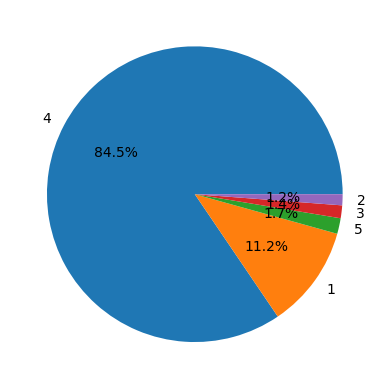

In [ ]:
plt.pie(data['intensidad'].value_counts().values,
        labels = data['intensidad'].value_counts().index,
        autopct='%1.1f%%')
plt.show()

Para hacer todo más sencillo y evitar asociaciones indeseadas, vamos a trabajar solo con minúsculas. Además, quitamos los signos de puntuación de los mensajes

In [ ]:
# # Revisamos la distribución original
# print("Distribución original:")
# print(data['intensidad'].value_counts())

# # Seleccionamos una cantidad más pequeña de clase 4 (undersampling)
# clase_4 = data[data['intensidad'] == 4].sample(1000, random_state=42)

# # Mantenemos las demás clases tal cual
# otras_clases = data[data['intensidad'] != 4]

# # Combinamos
# data = pd.concat([clase_4, otras_clases])
# data = data.sample(frac=1, random_state=42).reset_index(drop=True)

# # Verificamos la nueva distribución
# print("\nDistribución después de undersampling:")
# print(data['intensidad'].value_counts())


In [ ]:
# Convertimos a minúsculas
data['mensaje'] = data['mensaje'].map(lambda x: x.lower())

# Función para eliminar signos de puntuación
def eliminar_signos(texto):
    return re.sub(f"[{re.escape(string.punctuation)}]", "", texto)

# Aplicamos la función al dataset
data['mensaje'] = data['mensaje'].map(eliminar_signos)
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido la presi...,3
1,habrí­a que reabrir el caso el supremo se dedi...,3
2,me parece un poco exagerado pedir más de tres ...,3
3,parece que todos los delincuentes niegan las e...,3
4,preguntárselo al fracasado media carrera en 6 ...,4


Eliminamos las "stopwords" o palabras vacías. Las stopwords son palabras comunes que, en general, no contienen información relevante para el análisis de texto y suelen ser filtradas antes de procesar los datos. Ejemplos típicos de stopwords en español son: "el", "la", "los", "las", "un", "una", "de", "y", "o", etc.

In [ ]:
# Obtenemos las stopwords en español
stop_words = set(stopwords.words('spanish'))
lemmatizer = WordNetLemmatizer()

# Definimos una función para eliminar stopwords y lematizar
def filtrar_palabras(texto):
    palabras_filtradas = []
    for palabra in texto.split():
        if palabra not in stop_words:
            palabra_lema = lemmatizer.lemmatize(palabra)
            palabras_filtradas.append(palabra_lema)
    return ' '.join(palabras_filtradas)

# Aplicamos la función
data['mensaje'] = data['mensaje'].apply(filtrar_palabras)
data.head()

,mensaje,intensidad
0,cristina cifuentes podrí­a haber sido presiden...,3
1,habrí­a reabrir caso supremo dedica proteger s...,3
2,parece exagerado pedir tres años prisión cifue...,3
3,parece delincuentes niegan evidencias pruebas ...,3
4,preguntárselo fracasado medium carrera 6 meses...,4


Creamos los conjuntos de entrenamiento y de test:

In [ ]:
# Variables X e y
X = data['mensaje']
y = data['intensidad'] - 1  # Ahora las clases van de 0 a 4

# Dividimos el dataset en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Dividimos el conjunto de entrenamiento en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

# Convertimos a arrays
X_train = X_train.values
X_val = X_val.values
X_test = X_test.values
y_train = y_train.values
y_val = y_val.values
y_test = y_test.values

# Creamos datasets de TensorFlow
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))


In [ ]:
# Distribucion de clases en train val y test en porcentajes
train_counts = np.unique(y_train, return_counts=True)
val_counts = np.unique(y_val, return_counts=True)
test_counts = np.unique(y_test, return_counts=True)

print("Distribución de clases en el conjunto de entrenamiento:")
for label, count in zip(train_counts[0], train_counts[1]):
    print(f"Clase {label}: {count} ({(count / len(y_train)) * 100:.2f}%)")

print("Distribución de clases en el conjunto de validación:")
for label, count in zip(val_counts[0], val_counts[1]):
    print(f"Clase {label}: {count} ({(count / len(y_val)) * 100:.2f}%)")

print("Distribución de clases en el conjunto de prueba:")
for label, count in zip(test_counts[0], test_counts[1]):
    print(f"Clase {label}: {count} ({(count / len(y_test)) * 100:.2f}%)")



Distribución de clases en el conjunto de entrenamiento:
Clase 0: 880 (11.20%)
Clase 1: 95 (1.21%)
Clase 2: 110 (1.40%)
Clase 3: 6639 (84.49%)
Clase 4: 134 (1.71%)
Distribución de clases en el conjunto de validación:
Clase 0: 220 (11.20%)
Clase 1: 23 (1.17%)
Clase 2: 28 (1.42%)
Clase 3: 1660 (84.48%)
Clase 4: 34 (1.73%)
Distribución de clases en el conjunto de prueba:
Clase 0: 275 (11.20%)
Clase 1: 30 (1.22%)
Clase 2: 34 (1.38%)
Clase 3: 2075 (84.49%)
Clase 4: 42 (1.71%)


Mostramos un mensaje y su intensidad, simplemente para ver que todo va bien:

In [ ]:
for men, inte in train_dataset.take(1):
  print('mensaje: ', men.numpy())
  print('nivel de odio: ', inte.numpy())

mensaje:  b'da culo'
nivel de odio:  3


Mezclamos los datos de forma aleatoria:

In [ ]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [ ]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for men, inte in train_dataset.take(1):
  print('mensaje: ', men.numpy()[:3])
  print()
  print('nivel de odio: ', inte.numpy()[:3])

mensaje:  [b'menudo jeta cara p\xc3\xa1nfilo deber\xc3\xad\xc2\xadan prohibirle poner segunda dosis totalidad pa\xc3\xad\xc2\xads vacunada asco persona muerto hoyo vivo hoyo'
 b'mezquindad poca vida interior pobreza esp\xc3\xad\xc2\xadritu'
 b'majadero tan in\xc3\xbatil tan mal asesorado redondo consiguen enfadar mundo']

nivel de odio:  [3 3 3]


Definimos y configuramos un codificador de texto utilizando la capa TextVectorization

In [ ]:
# Creamos una capa de vectorización de texto
vectorizador = tf.keras.layers.TextVectorization(max_tokens=5000)

# Se extraen solo los textos del conjunto de datos de entrenamiento
def extraer_texto(texto, etiqueta):
    return texto

# Adaptamos el vectorizador al texto del conjunto de datos de entrenamiento
dataset_texto = train_dataset.map(extraer_texto)
vectorizador.adapt(dataset_texto)

In [ ]:
# Obtenemos el vocabulario aprendido por la capa de vectorización
vocabulario = np.array(vectorizador.get_vocabulary())

# Mostramos las primeras 20 palabras del vocabulario
primeras_20_palabras = vocabulario[:20]
primeras_20_palabras

array(['', '[UNK]', 'si', 'mierda', 'puta', 'ser', 'asco', 'gobierno',
       'q', 'panfleto', 'gente', 'españa', 'paí\xads', 'vaya', 'va',
       'vergüenza', 'basura', 'gentuza', 'gilipollas', 'hacer'],
      dtype='<U25')

# Ejercicio

Construye una RNN que pueda detectar el nivel de odio de un mensaje.

**Tenéis plena liberta para realizar la red y para hacer cualquier modificación a los datos.**

Vectorizamos los distintos fragmentos de texto

In [ ]:
def vectorizar_texto(texto, etiqueta):
    texto = tf.expand_dims(texto, -1)
    return vectorizador(texto), etiqueta

train_ds = train_dataset.map(vectorizar_texto)
val_ds = val_dataset.map(vectorizar_texto)
test_ds = test_dataset.map(vectorizar_texto)


Creamos un modelo con dos capas LSTM y un perceptrón multicapa para realizar la clasificación.

In [ ]:
tamaño_embedding = 64
num_clases = 5

modelo = keras.Sequential([
    layers.Embedding(input_dim=5000, output_dim=128, mask_zero=True),
    layers.Bidirectional(layers.LSTM(64, return_sequences=True)),
    layers.Bidirectional(layers.LSTM(32)),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(5, activation='softmax')
])

In [ ]:
modelo.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
modelo.build(input_shape=(None, None))  # secuencias de longitud variable
modelo.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, None, 128)      │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, None, 128)      │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 64)             │        41,216 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 784,517 (2.99 MB)

 Trainable params: 784,517 (2.99 MB)

 Non-trainable params: 0 (0.00 B)

Entrenamos el modelo con early stop para evitar el sobreajuste

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

In [ ]:
from sklearn.utils import class_weight

pesos = class_weight.compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(pesos))


In [ ]:
historial = modelo.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=[early_stopping],
    epochs=20,
    class_weight=class_weights
)

Epoch 1/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 77s 529ms/step - accuracy: 0.4546 - loss: 1.6226 - val_accuracy: 0.6326 - val_loss: 1.3378
Epoch 2/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 68s 413ms/step - accuracy: 0.6927 - loss: 1.3726 - val_accuracy: 0.6336 - val_loss: 0.9834
Epoch 3/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 83s 424ms/step - accuracy: 0.7516 - loss: 0.8514 - val_accuracy: 0.7338 - val_loss: 0.7522
Epoch 4/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 54s 442ms/step - accuracy: 0.8216 - loss: 0.5071 - val_accuracy: 0.7399 - val_loss: 0.8731
Epoch 5/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 77s 398ms/step - accuracy: 0.8810 - loss: 0.2499 - val_accuracy: 0.7313 - val_loss: 0.9450
Epoch 6/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 48s 395ms/step - accuracy: 0.8980 - loss: 0.1821 - val_accuracy: 0.7812 - val_loss: 0.9408
Epoch 7/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 81s 384ms/step - accuracy: 0.9212 - loss: 0.1471 - val_accuracy: 0.7817 - val_loss: 0.9576
Epoch 8/20
123/123 ━━━━━━━━━━━━━━━━━━━━ 79s 360ms/step - accuracy: 0.9333 - loss: 0

In [ ]:
modelo.evaluate(test_ds)

39/39 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step - accuracy: 0.7165 - loss: 0.7715


[0.7480336427688599, 0.725570023059845]

In [ ]:
from sklearn.metrics import classification_report
y_pred = modelo.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes))

39/39 ━━━━━━━━━━━━━━━━━━━━ 7s 150ms/step
              precision    recall  f1-score   support

           0       0.33      0.60      0.43       275
           1       0.16      0.10      0.12        30
           2       0.03      0.03      0.03        34
           3       0.94      0.77      0.85      2075
           4       0.09      0.45      0.15        42

    accuracy                           0.73      2456
   macro avg       0.31      0.39      0.31      2456
weighted avg       0.84      0.73      0.77      2456



Ejemplo de predicción con un mensaje nuevo

In [ ]:
mensaje_nuevo = tf.constant(['político mentiroso inútil'])
mensaje_vectorizado = vectorizador(mensaje_nuevo)
prediccion = modelo.predict(mensaje_vectorizado)
print("Predicción de intensidad de odio:", np.argmax(prediccion) + 1)

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 830ms/step
Predicción de intensidad de odio: 4


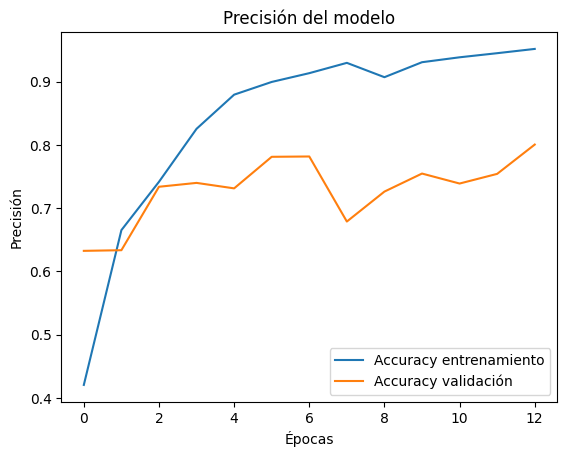

In [ ]:
plt.plot(historial.history['accuracy'], label='Accuracy entrenamiento')
plt.plot(historial.history['val_accuracy'], label='Accuracy validación')
plt.xlabel('Épocas')
plt.ylabel('Precisión')
plt.title('Precisión del modelo')
plt.legend()
plt.show()


Como hemos visto en el preprocesamiento de los datos, el dataset es muy desbalanceado, por lo que hacer un buen modelo con el resulta muy complicado. Hemos intentado hacer undersampling de la clase ganadora pero los datos disminuyen demasiado y el rendimiento del modelo baja.

Tras realizar un entrenamiento utilizando distintas técnicas para evitar el sobreajuste como early stopping, dropout o class weight llegamos a la conclusión de que con un conjunto de datos tan pequeño y desbalanceado es muy compliado crear un modelo competitivo.

Hemos intentado hacer transfer learning para conseguir mejores resultados pero hemos tenido complicaciones para encontrar y descargar un modelo preentrenado con capas LSTM .

También hemos pensado en hacer un oversampling de las clases minoritarias ya que estas tenían al rededor de 300 instancias. Para ello teníamos pensado usar sinónimos para hacer un data augmentation sin sesgar demasiado los datos. No hemos tenido tiempo para ello y tampoco sabemos si se puede hacer o es un mala práctica.